In [17]:
import pyprind
import pandas as pd
import os

labels = {'pos' : 1, 'neg' : 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join('aclImdb', s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 
                     'r', encoding = 'utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index = True)
            pbar.update()        

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:52


In [18]:
df.columns = ['review', 'sentiment']

In [19]:
df.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


In [20]:
df.shape

(50000, 2)

In [21]:
df.tail()

,review,sentiment
49995,"Towards the end of the movie, I felt it was to...",0
49996,This is the kind of movie that my enemies cont...,0
49997,I saw 'Descent' last night at the Stockholm Fi...,0
49998,Some films that you pick up for a pound turn o...,0
49999,"This is one of the dumbest films, I've ever se...",0


In [22]:
import numpy as np
np.random.seed(42)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('movie_data.csv', index = False, encoding = 'utf-8')

In [25]:
df = pd.read_csv('movie_data.csv', encoding = 'utf-8')
df.head(10)

,review,sentiment
0,I was taken to this film by a friend and was s...,1
1,This trash version of `Romeo and Juliet' passe...,1
2,"There is a lot to like in this film, despite i...",1
3,"People have often been uncomfortable with ""The...",1
4,I don't get this. The movie obviously has a pr...,0
5,I opted to see the film at the recent Dubai Fi...,0
6,Jamie Foxx does a fine job of impersonating th...,1
7,The oddly-named Vera-Ellen was to movie dancin...,0
8,"First of all, the entire script is mostly impr...",1
9,A great gangster film.Sam Mendes has directed ...,1


In [26]:
df.shape

(50000, 2)

In [29]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
docs = np.array(['The sun is shining',
                'The weather is sweet', 
                'The sun is shining, the weather is sweet,',
                'and one and one is two'])
bag = count.fit_transform(docs)

In [34]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [35]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [0 2 0 1 1 1 2 0 1]
 [2 1 2 0 0 0 0 1 0]]


In [36]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf = True, 
                        norm = 'l2',
                        smooth_idf = True)
np.set_printoptions(precision = 2)
print(tfidf.fit_transform(count.fit_transform(docs)).toarray())

[[0.   0.38 0.   0.57 0.57 0.   0.46 0.   0.  ]
 [0.   0.38 0.   0.   0.   0.57 0.46 0.   0.57]
 [0.   0.46 0.   0.35 0.35 0.35 0.56 0.   0.35]
 [0.66 0.17 0.66 0.   0.   0.   0.   0.33 0.  ]]


In [37]:
df.loc[0, 'review'][-50:]

'a film that I will promote to all who will listen.'

In [45]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                          text)
    text = (re.sub('[\W]+',' ', text.lower())) + ' '.join(emoticons).replace('-', '')
    return text

In [46]:
for i in range(5):
    print(preprocessor(df.loc[i, 'review'][-50:]))

a film that i will promote to all who will listen 
 to the first group my vote is eight 
0s high school melodrama or 70s kitsch in general 
ther testament to what a great actor al pacino is 
d actually and eels come one really 


In [47]:
df['review'] = df['review'].apply(preprocessor)

In [49]:
def tokenizer(text):
    return text.split()

In [50]:
tokenizer('This is a test example')

['This', 'is', 'a', 'test', 'example']

In [53]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [55]:
tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [60]:
import nltk

from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot') if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

In [61]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
tfidf = TfidfVectorizer(strip_accents = None, lowercase = False, preprocessor = None)
param_grid = [{'vect__ngram_range' : [(1,1)],
              'vect__stop_words' : [stop, None],
              'vect__tokenizer' : [tokenizer, tokenizer_porter],
              'clf__penalty' : ['l1', 'l2'], 
              'clf__C' : [1.0, 10.0, 100.0]}]

lr_tfidf = Pipeline([('vect', tfidf),
                    ('clf', LogisticRegression(random_state = 42, solver = 'liblinear'))])
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid, scoring = 'accuracy', cv = 3, verbose = 3, n_jobs = -1)

In [65]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 38.3min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [66]:
import joblib

joblib.dump(gs_lr_tfidf, 'gs_lr_tfidf.pkl')

['gs_lr_tfidf.pkl']

In [67]:
best_lr_clf = gs_lr_tfidf.best_estimator_

In [71]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [70]:
y_prediction = best_lr_clf.predict(X_train)
print('Accuracy:', accuracy_score(y_train, y_prediction))
print('precision:', precision_score(y_train, y_prediction))
print('recall:', recall_score(y_train, y_prediction))
print('f1_score:', f1_score(y_train, y_prediction))

Accuracy: 0.9878804847806087
precision: 0.9876318084515976
recall: 0.9883370358616312
f1_score: 0.9879842963080462


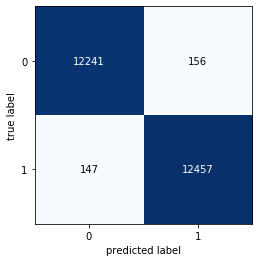

In [72]:
conf_mat = confusion_matrix(y_train, y_prediction)
plot_confusion_matrix(conf_mat)
import matplotlib.pyplot as plt
plt.show()

In [82]:
false_positives = X_train[(y_train == 0) & (y_prediction == 1)]
false_negatives = X_train[(y_train == 1) & (y_prediction == 0)]

In [88]:
false_negatives[0]

'a young woman comes to the home town of his husband after he passed away in an accident she barely settles down in this small town but shortly after loses her little son in a kidnapping and all her hopes this could lead to all kinds following plots in a normal movie find a new partner and being happy finally or depressed enough to struggle and finally kill herself she does try to kill herself but not after a series of severe fights with god she trusts in god only to find that god seems to forgive everyone even the killer well i should be careful here about god the movie doesn t mean a thing against god the way the movie deals the issue is quite interesting not in the woman s point of view or from god s perspective in this way there would be lots of grass growing clouds flying views i suppose rather it s from a third party s eye the movie let us to perceive and doesn t explain a thing the movie wouldn t be so interesting were there only the woman there s this man who s everywhere aroun

In [89]:
false_positives[0]

0      after seeing forever hollywood it would be nat...
1      the story goes something like this a small tow...
2      you know i always fancy disturbing or strange ...
3      this is without a doubt the most hilarious mov...
4      another day this movie requires you to watch i...
                             ...                        
151    yes the movie is not a piece of art but the fi...
152    what can i say i m a secret fan of over the to...
153    how much can you really say about a condom wit...
154    rip off of scream or especially i know what yo...
155    stone has tried another type of movie any give...
Name: 0, Length: 156, dtype: object